In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scikitplot as skplt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import plot_tree


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, plot_confusion_matrix, f1_score, roc_auc_score, accuracy_score, log_loss

## Model 1 - Inferential Model
The first model to build is a simple model that while lacking the performance of our churn filter, will be easily digested in order to explore which aspects of customer profiles are contributing to churn and thusly give departure points to analyze the business practices that might contribute to these numbers. 

### Model Selection

Two immediate models come to mind regarding simple/interpretable models for classification:
* Logistic Regression
    * When Data has a linear relationship.
    * Simplest form as the Coefficents produced directly relate to the rate of change of each feature has on the model's Decision.
* Decision Tree
    * When Data does not have a linear relationship.
    * Provides mapped out decision tree of how it came to decisions.
    
Addtionally to providing easily digestable results, these algorithms scale extremely well in performance and would be appropriate solutions to enterprise level of data.

In [67]:
#load data

df = pd.read_csv("simple_preprocessed_scaled_df.csv")
df.head()

#split data
X, y = df.iloc[:,:12], df.iloc[:,-1]

#train_test_split, 20% observations aside for testing, note will forgo validation split for this inferential exercise
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42, stratify=y)

In [68]:
X.head()

,CreditScore,Gender,Age,Tenure,Balance,Balance_Is_0,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany
0,-31.5288,1,0.110042,2,0.00,1,-0.5302,1,1,101348.88,1.0,0.0
1,-42.5288,1,0.085945,1,83807.86,0,-0.5302,0,1,112542.58,0.0,0.0
2,-148.5288,1,0.110042,8,159660.80,0,1.4698,1,0,113931.57,1.0,0.0
3,48.4712,1,0.035934,1,0.00,1,0.4698,0,0,93826.63,1.0,0.0
4,199.4712,1,0.133573,2,125510.82,0,-0.5302,1,1,79084.10,0.0,0.0


In [69]:
#data set is imbalanced (approx 20% of records are churrned) so I will calculate the class weights as an input to the LogisticRegression model
df_class_weights= compute_class_weight('balanced', classes=[0,1], y=y)
df_class_weights

array([0.62790406, 2.45459008])

For model optimziation, I will utlized ROC AUC as my lead scoring metric, as I want to optimize models to find the largest boundary between TPR/FPR.

Lets start by running a quick cross validation on both model types to see if there is any substantial difference.

In [70]:
#scaling data to optimize data for LogisiticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


log_reg_cv = cross_val_score(LogisticRegression(class_weight={0:0.62790406, 1:2.45459008}), X_train_scaled, y_train, cv=5, scoring='roc_auc')
dec_tree_cv = cross_val_score(DecisionTreeClassifier(class_weight={0:0.62790406, 1:2.45459008}), X_train, y_train, cv=5, scoring='roc_auc')

print('The Avg Area Under the ROC curve for Logistic Regression Classification averages: ' + str(round(np.mean(log_reg_cv),4)))
print('The Avg Area Under the ROC curve for Decision Tree Classification averages: ' + str(round(np.mean(dec_tree_cv),4)))

The Avg Area Under the ROC curve for Logistic Regression Classification averages: 0.7704
The Avg Area Under the ROC curve for Decision Tree Classification averages: 0.6826


The Cross Val showed promising results in regards to maximizing the TPR/FPR ratios for either model type. Considering the scalability of each algorithm I'll optimize each to validate my findings.

In [204]:
#grid search for LogisticRegressor

l1_grid_params = {
                    'solver' : ['liblinear', 'saga'],
                    'C' : [i for i in range(11)],
                    'max_iter' : [1000,5000,10000,50000]
}

l2_grid_params = {
                    'solver' : ['newton-cg', 'lbfgs','sag', 'saga'],
                    'C' : [i for i in range(11)],
                    'max_iter' : [1000,5000,10000,50000]
}

en_grid_params = {
                    'solver' : ['newton-cg', 'lbfgs','sag', 'saga'],
                    'C' : [i for i in range(11)],
                    'max_iter' : [1000,5000,10000,50000],
                    'l1_ratio' : [.001, .01, .1, .25, .5, .75, .9, .99, .999]
}

log_params = [l1_grid_params, l2_grid_params, en_grid_params]
log_penalty = ['l1','l2', 'elasticnet']

for p_grid, log_penalty in zip(log_params, log_penalty):
    grid = GridSearchCV(LogisticRegression(random_state = 42, class_weight={0:0.62790406, 1:2.45459008}, penalty=log_penalty), p_grid,cv = 10, scoring='precision', error_score=np.nan, verbose=2, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    
    print('Penalty: ' + str(log_penalty))
    print('Best Score: ' + str(grid.best_score_))
    print('Best Esitmator: ' +str(grid.best_estimator_) +'\n')

Fitting 10 folds for each of 88 candidates, totalling 880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 306 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 509 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 880 out of 880 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Penalty: l1
Best Score: 0.3789548481597066
Best Esitmator: LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   max_iter=1000, penalty='l1', random_state=42, solver='saga')

Fitting 10 folds for each of 176 candidates, totalling 1760 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1760 out of 1760 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Penalty: l2
Best Score: 0.3787630772372563
Best Esitmator: LogisticRegression(C=2, class_weight={0: 0.62790406, 1: 2.45459008},
                   max_iter=1000, random_state=42, solver='sag')

Fitting 10 folds for each of 1584 candidates, totalling 15840 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3804 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 5450 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 8432 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 12344 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 14424 tasks      | elapsed:  1.5min


Penalty: elasticnet
Best Score: 0.3789548481597066
Best Esitmator: LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   l1_ratio=0.75, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')



[Parallel(n_jobs=-1)]: Done 15840 out of 15840 | elapsed:  1.8min finished


GridSearch produced similiar results among different solvers and Regulraization stengths. Chose best performing ElasticNet solver to apply to data and analyze the effects the parameters have on the churn potential.

In [72]:
#build helper function to display results of model fit on test data

def results_pipe(model):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled, y_train)
    
    print('Model Results')
    print('Accuracy: ' + str(accuracy_score(y_test, model.predict(X_test_scaled))))
    print('F1 ' + str(f1_score(y_test, model.predict(X_test_scaled))))
    print('ROC AUC :' + str(roc_auc_score(y_test, model.predict(X_test_scaled)))+'\n')
    print(classification_report(y_test,model.predict(X_test_scaled))+'\n')
    
    
    plt.figure(figsize=(40,10))
    grid = plt.GridSpec(1, 4, wspace=0.5, hspace=0.4)
    ax1 = plt.subplot(grid[0,0])
    plot_confusion_matrix(model, X_test_scaled, y_test, ax= ax1)
    ax2 = plt.subplot(grid[0,1])
    skplt.metrics.plot_roc(y_test, model.predict_proba(X_test_scaled), ax=ax2)
    ax3 = plt.subplot(grid[0,2])
    skplt.metrics.plot_precision_recall(y_test, model.predict_proba(X_test_scaled), ax=ax3)
    
    if str(model)[0] == 'L':
        zipped_cols_coefs = list(zip(X.columns,model.coef_[0]))
        coef_df = pd.DataFrame(zipped_cols_coefs,columns=['Feature','Coef'])
        coef_df.Coef = round(coef_df.Coef,4)
        coef_df.sort_values('Coef',ascending=False, key=abs)
        coef_df.set_index('Feature')
        coef_df = coef_df.sort_values('Coef', key=abs,ascending=False)
        ax4 = plt.subplot(grid[0,3])
        ax4 = sns.barplot(x=coef_df.Coef, y=coef_df.Feature,color='#4287f5')
        yabs_max = 1
        ax4.set_xlim(xmin=-yabs_max, xmax=yabs_max)
    else:
        zipped_cols_fi = list(zip(X.columns,model.feature_importances_))
        fi_df = pd.DataFrame(zipped_cols_fi,columns=['Feature','Feature Importance'])
        fi_df['Feature Importance'] = round(fi_df['Feature Importance'],4)
        fi_df =fi_df.sort_values('Feature Importance',ascending=False, key=abs)
        ax4 = plt.subplot(grid[0,3])
        ax4 = sns.barplot(x=fi_df['Feature Importance'], y=fi_df.Feature, color='#4287f5')
        yabs_max = 1
        ax4.set_xlim(xmin=-yabs_max, xmax=yabs_max)

Model Results
Accuracy: 0.7095
F1 0.5038428693424424
ROC AUC :0.7152013338454017

              precision    recall  f1-score   support

           0       0.91      0.71      0.79      1593
           1       0.39      0.72      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.80      0.71      0.74      2000




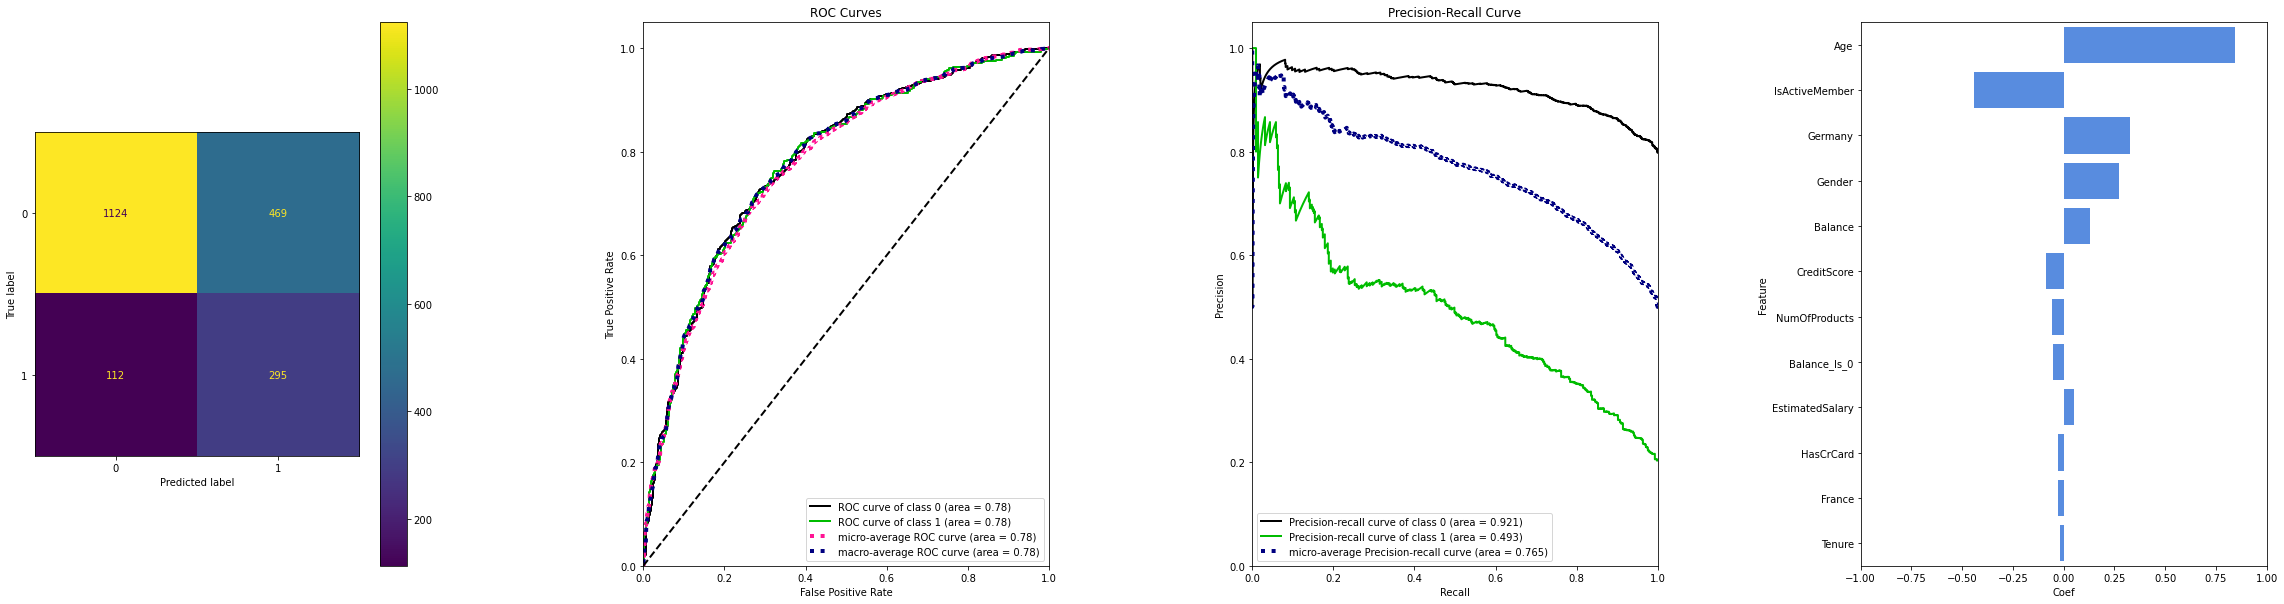

In [73]:
#print and graph the results of fitting LogisticRegression model on the data

results_pipe(LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   l1_ratio=0.75, max_iter=5000, penalty='elasticnet',
                   random_state=42, solver='saga'))

#### LogisticRegression Results
The fit of the Regression model provided moderate results as the classifer was somewhat adept at capturing more than 2/3rds of the positive class with the correct label although a considerable amount of miss classfication within the negative class did occur. Considering the imbalance between the classes it is not surprising that the model was able to have greater success in identifying the negative class(non-Exited/current) as displayed by the classification report and F1-score.

In reiewing the model's Precision-Recall Curve, we can see that Precision for our Positive class maxes out around ~.85 so Type 1 Errors are an inevitable outcome of the model. Additionally we can observe that 

The model is showing considerable improvement over a baseline guessing estimate pltted along the ROC curve, so the findings should be insightful to which factors are contributing to the positive class.

Observing at the coefficents, (noting they are all scaled to reflect the parameter's z-score) Age provides the greatest affect on the model's score followed by the binary inputs of IsActiveMember, Germany and Gender.

Drawing your attention to the dataframe below, you can observe the baseline probability of the model chooseing the Positive (Exited) class in the non real world scenario of having all other units effect nullified (Scaled to 0/Parameter mean), along with each singular input's affect on the model when either activated as a binary input or adjusted by 1 Standard Deviation. As expected, Age holds the most considerable sway over the models adjustment in probability. Likely indicating that the Age input is a major contributor to customer base's churn.

In [196]:
lm = LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   l1_ratio=0.75, max_iter=5000, penalty='elasticnet',
                   random_state=42, solver='saga')


lm.fit(X_train_scaled, y_train)

effect_df = pd.DataFrame(columns=['Parameter', 'Parameter Probability', 'Delta From Baseline','Unit Change Represented'])
base_input = np.zeros((12,))
base_prob = lm.predict_proba(base_input.reshape(1,-1))[0][1]
effect_df = effect_df.append({'Parameter':'Baseline', 'Parameter Probability': round(base_prob,4), 'Delta From Baseline': '--' , 'Unit Change Represented' : '--'}, ignore_index=True)


for i in range(len(units_change)):
    base_input = np.zeros((12,))
    base_input[i] = 1
    input_prob = lm.predict_proba(base_input.reshape(1,-1))[0][1]
    effect_df = effect_df.append({'Parameter':X.columns[i], 
                                  'Parameter Probability': round(input_prob,4), 
                                  'Delta From Baseline': round(input_prob-base_prob,4),
                                  'Unit Change Represented' : (lambda x : round(X.iloc[:,i].std(),2) if len(X.iloc[:,i].value_counts()) > 2 else 'Binary')(i)  }, ignore_index=True)

effect_df

,Parameter,Parameter Probability,Delta From Baseline,Unit Change Represented
0,Baseline,0.4204,--,--
1,CreditScore,0.3997,-0.0207,96.65
2,Gender,0.4880,0.0676,Binary
3,Age,0.6285,0.2081,0.26
4,Tenure,0.4160,-0.0045,2.89
5,Balance,0.4641,0.0437,62397.4
6,NumOfProducts,0.4064,-0.014,0.58
7,HasCrCard,0.4130,-0.0074,Binary
8,IsActiveMember,0.3185,-0.1019,Binary
9,EstimatedSalary,0.4328,0.0124,57510.5


### DecisionTreeClassifer

For the next step in the inferential analysis we will turn our attention to the DecisionTree or CART model. This relatively simple form of the tree models seeks to "split" the data using decision points within the ranges of the input parameters. Decision for the splits are made based on how "pure" the resulting node or leaf would be, commonly measured in 'Gini' or 'Entropy'. 

As the goal of this exercise is to pull simple inference to build a case of cause of customer churn. Lets start by analysing how a simple a model we can create while maintaining performance.

In [58]:
df = pd.read_csv('simple_preprocessed_unscaled_df.csv')

#split data
X, y = df.iloc[:,:12], df.iloc[:,-1]

#train_test_split, 20% observations aside for testing, note will forgo validation split for this inferential exercise
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42, stratify=y)

In [59]:
size_grid = {'max_depth':[i for i in range(1,10)]}

f1_depth_grid  = GridSearchCV(DecisionTreeClassifier(random_state=42,class_weight={0:0.62790406, 1:2.45459008}), 
                     size_grid, cv = 10, scoring='f1',
                    error_score=np.nan, n_jobs=-1)

roc_depth_grid  = GridSearchCV(DecisionTreeClassifier(random_state=42,class_weight={0:0.62790406, 1:2.45459008}), 
                     size_grid, cv = 10, scoring='roc_auc',
                    error_score=np.nan, n_jobs=-1)

f1_depth_grid.fit(X, y)
roc_depth_grid.fit(X, y)



GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight={0: 0.62790406,
                                                            1: 2.45459008},
                                              random_state=42),
             n_jobs=-1, param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

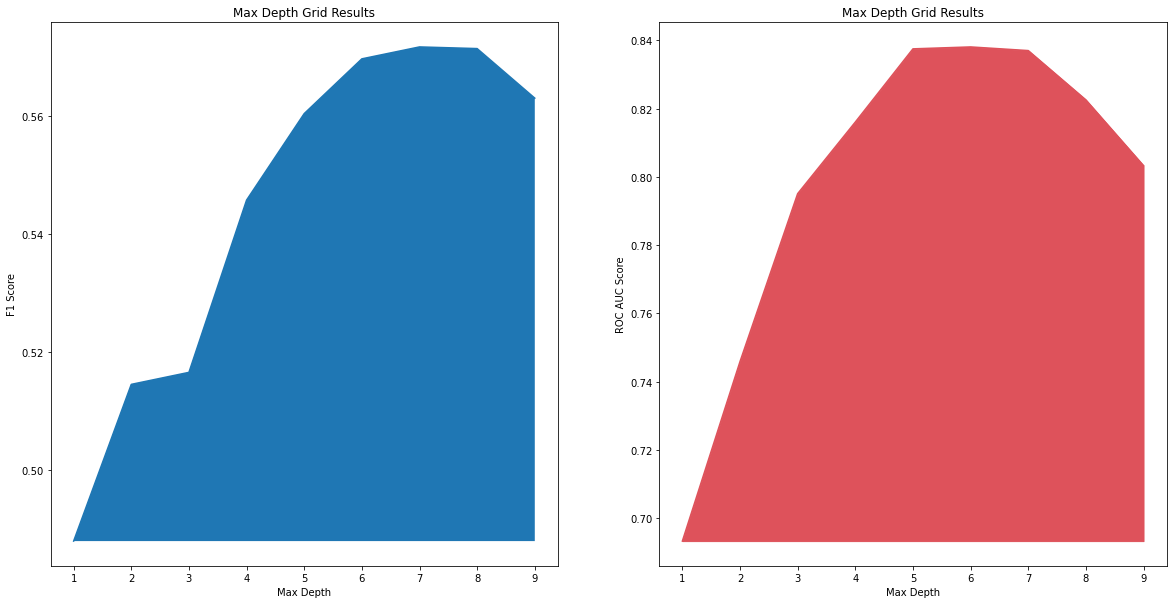

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1, ax2 = axes

sns.lineplot(x=[i for i in range(1,10)], y= [i for i in f1_depth_grid.cv_results_['mean_test_score']], ax= ax1)
ax1.set_title('Max Depth Grid Results')
ax1.fill_between(x=[i for i in range(1,10)], y1=[i for i in f1_depth_grid.cv_results_['mean_test_score']], y2=min([i for i in f1_depth_grid.cv_results_['mean_test_score']]))
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('F1 Score')



sns.lineplot(x=[i for i in range(1,10)], y= [i for i in roc_depth_grid.cv_results_['mean_test_score']],color='#de525b', ax=ax2)
ax2.set_title('Max Depth Grid Results')
ax2.fill_between(x=[i for i in range(1,10)], y1=[i for i in roc_depth_grid.cv_results_['mean_test_score']], y2=min([i for i in roc_depth_grid.cv_results_['mean_test_score']]),color='#de525b')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('ROC AUC Score');

In [26]:
#gridsearch the contstraints of the DecisonTree algroithm, note the decision to limit depth in order to keep a relatively simple decision structure

grid_params = {
               'min_samples_leaf' : [i for i in range(1,100)] ,
               'min_samples_split' : [i for i in range(115,136)]}


grid = GridSearchCV(DecisionTreeClassifier(random_state = 42,
                            class_weight={0:0.8, 1:0.2}, max_depth=4, criterion='entropy'), grid_params, cv=5, scoring='roc_auc', error_score=np.nan, verbose=2, n_jobs=-1)

grid.fit(X, y)

print('Best Score: ' + str(grid.best_score_))
print('Best Esitmator: ' +str(grid.best_estimator_))

Fitting 5 folds for each of 441 candidates, totalling 2205 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:    3.9s


Best Score: 0.791527334916882
Best Esitmator: DecisionTreeClassifier(class_weight={0: 0.8, 1: 0.2}, criterion='entropy',
                       max_depth=3, min_samples_leaf=40, min_samples_split=115,
                       random_state=42)


[Parallel(n_jobs=-1)]: Done 2205 out of 2205 | elapsed:   10.4s finished


In [15]:
results_pipe(DecisionTreeClassifier(class_weight={0: 0.62790406, 1: 2.45459008},
                       criterion='entropy', max_depth=5, min_samples_leaf=29,
                       min_samples_split=115, random_state=42), X,y)

ValueError: Number of labels=8000 does not match number of samples=10000

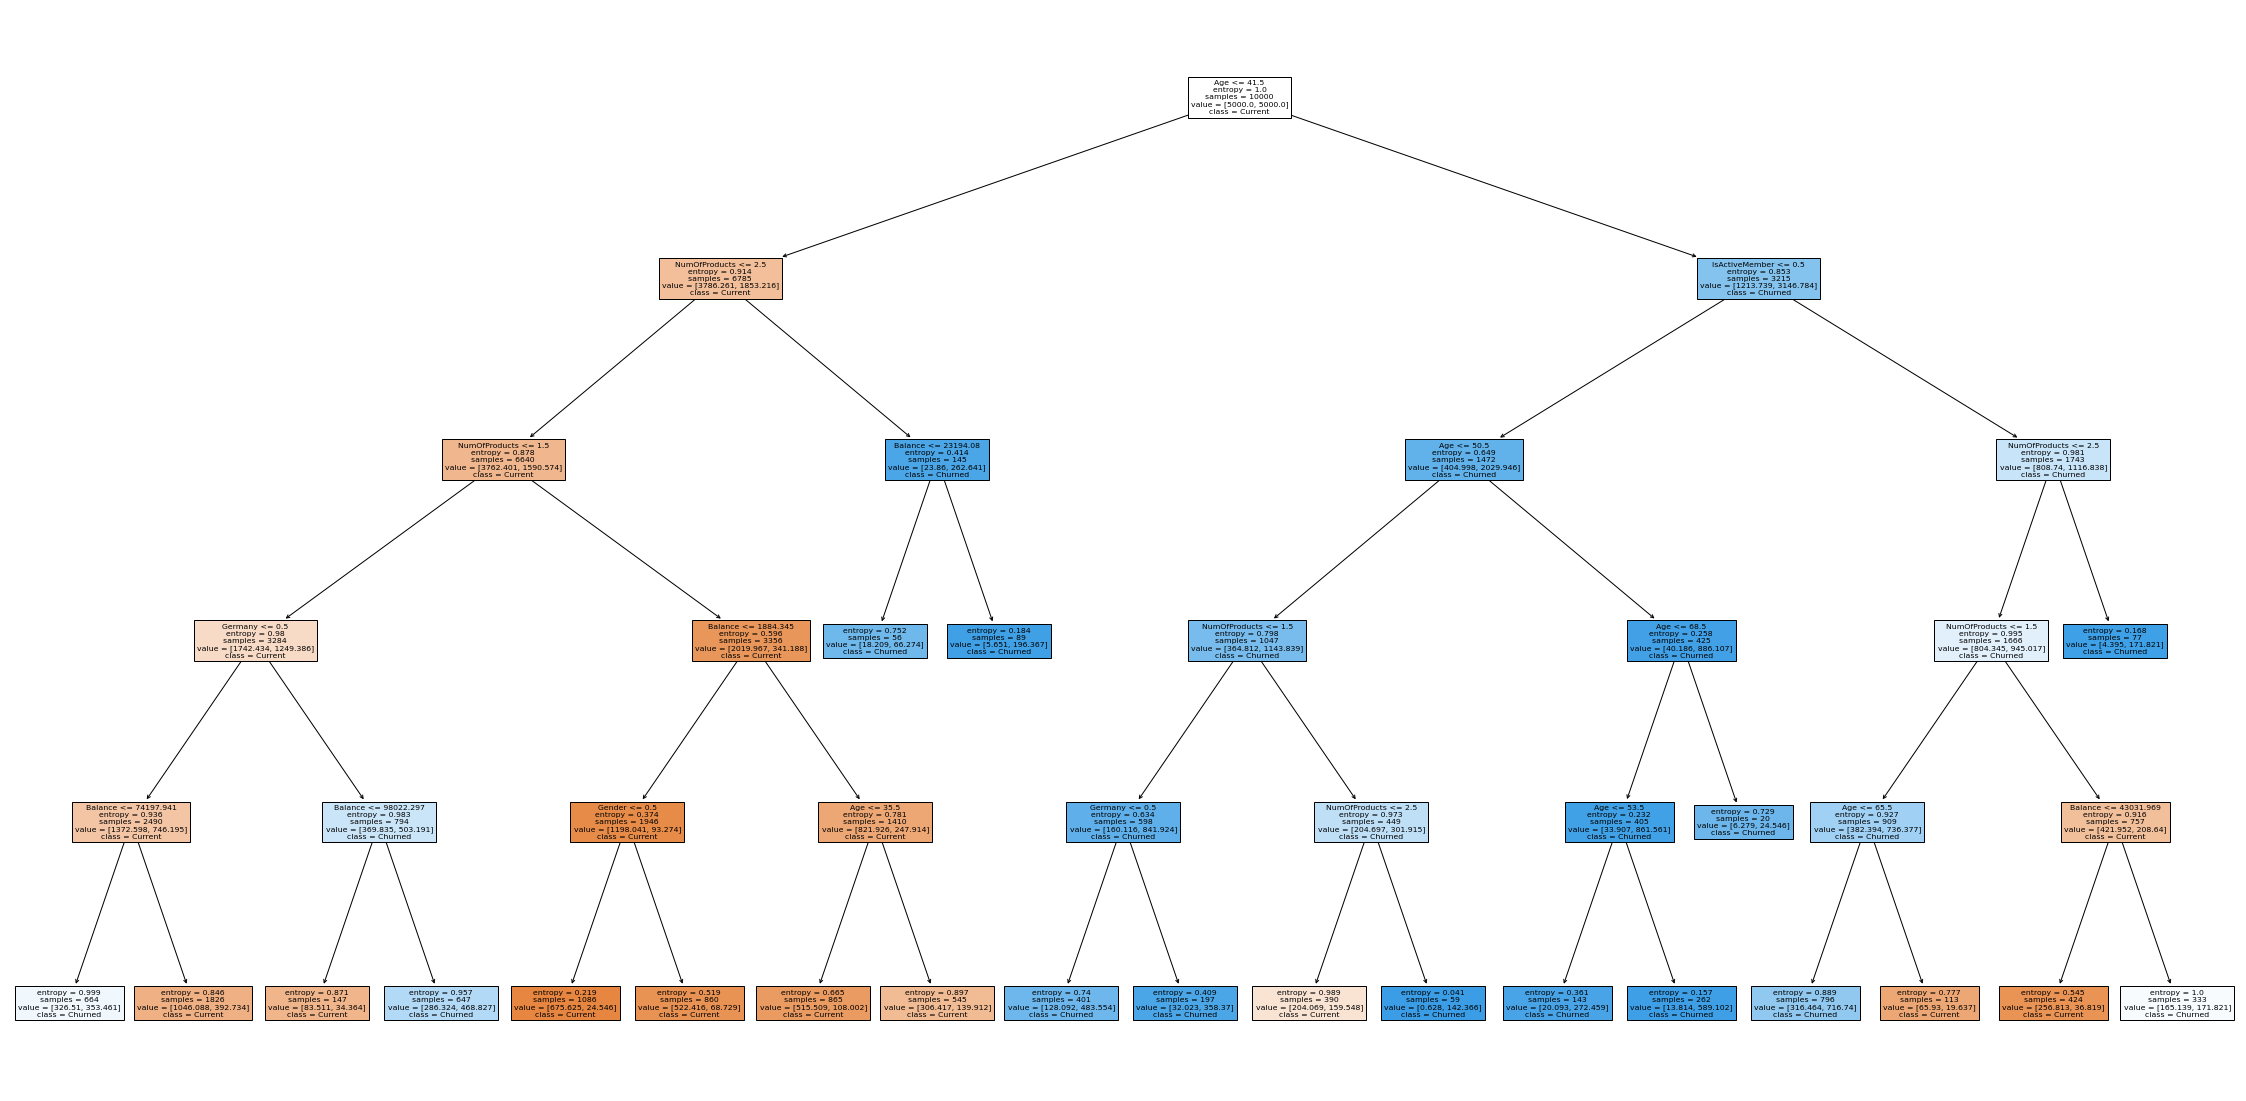

In [63]:
dt = DecisionTreeClassifier(class_weight={0:0.62790406, 1:2.45459008},
                       criterion='entropy', max_depth=5, min_samples_leaf=20,
                       min_samples_split=115, random_state=42)
dt.fit(X, y)

fig = plt.figure(figsize=(40,20))
_ = plot_tree(dt, 
                   feature_names=X.columns,  
                   class_names=['Current', 'Churned'],
                   filled=True)

In [64]:
dt.feature_importances_

array([0.        , 0.00728591, 0.42443831, 0.        , 0.09610416,
       0.        , 0.35820243, 0.        , 0.0782518 , 0.        ,
       0.        , 0.03571739])

In [65]:
X.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'Balance_Is_0',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'France', 'Germany'],
      dtype='object')